<a href="https://colab.research.google.com/github/SoumyadipRoy17/DeepLearning-FastAI-/blob/main/NTV_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [18]:
!pip install transformers torch pandas biopython openpyxl --quiet


In [19]:
import pandas as pd

# Example: Reading from Excel and standardizing headers
df_raw = pd.read_excel('/content/41586_2018_461_MOESM3_ESM (2).xlsx')
df_raw.columns = df_raw.iloc[1]
variants = df_raw[2:].reset_index(drop=True)

# Select and rename as needed:
variants = variants.rename(columns={
    'chromosome': 'chrom',
    'position (hg19)': 'pos',
    'reference': 'ref',
    'alt': 'alt',
    'function.score.mean': 'score',
    'func.class': 'class'
})
variants = variants[['chrom', 'pos', 'ref', 'alt', 'score', 'class']]


In [20]:
from transformers import AutoTokenizer, AutoModelForMaskedLM
import torch

model_id = "InstaDeepAI/nucleotide-transformer-v2-50m-multi-species"
tokenizer = AutoTokenizer.from_pretrained(model_id)
model = AutoModelForMaskedLM.from_pretrained(model_id)
model.eval()

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/129 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/101 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

The repository for InstaDeepAI/nucleotide-transformer-v2-50m-multi-species contains custom code which must be executed to correctly load the model. You can inspect the repository content at https://hf.co/InstaDeepAI/nucleotide-transformer-v2-50m-multi-species.
You can avoid this prompt in future by passing the argument `trust_remote_code=True`.

Do you wish to run the custom code? [y/N] y


esm_config.py: 0.00B [00:00, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/InstaDeepAI/nucleotide-transformer-v2-50m-multi-species:
- esm_config.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


The repository for InstaDeepAI/nucleotide-transformer-v2-50m-multi-species contains custom code which must be executed to correctly load the model. You can inspect the repository content at https://hf.co/InstaDeepAI/nucleotide-transformer-v2-50m-multi-species.
You can avoid this prompt in future by passing the argument `trust_remote_code=True`.

Do you wish to run the custom code? [y/N] y


modeling_esm.py: 0.00B [00:00, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/InstaDeepAI/nucleotide-transformer-v2-50m-multi-species:
- modeling_esm.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


model.safetensors:   0%|          | 0.00/224M [00:00<?, ?B/s]


A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.0.2 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "<frozen runpy>", line 198, in _run_module_as_main
  File "<frozen runpy>", line 88, in _run_code
  File "/usr/local/lib/python3.11/dist-packages/colab_kernel_launcher.py", line 37, in <module>
    ColabKernelApp.launch_instance()
  File "/usr/local/lib/python3.11/dist-packages/traitlets/config/application.py", line 992, in launch_instance
    app.start()
  File "/usr/local/lib/python3.11/dist-packages/ipykernel/kernelapp.py", line 712, in start
    self.io_loop.start()
  File "/usr/local/lib/python3.11/dist-package

In [21]:
from Bio import SeqIO

def get_sequence(chrom, pos, ref, alt, genome_fasta, window=12001):
    fasta_dict = SeqIO.to_dict(SeqIO.parse(genome_fasta, "fasta"))
    key = list(fasta_dict.keys())[0]  # Adjust if needed (e.g., '17', 'chr17')
    seq = fasta_dict[key].seq

    start = max(0, pos - window//2 - 1)
    end = min(len(seq), start + window)
    seq_context = seq[start:end]
    rel_pos = (pos - 1) - start

    fasta_ref = seq[(pos-1):(pos-1)+len(ref)].upper()
    if fasta_ref != ref.upper():
        raise ValueError(f"Reference mismatch at {chrom}:{pos}")

    seq_ref = seq_context[:rel_pos] + ref + seq_context[rel_pos+len(ref):]
    seq_alt = seq_context[:rel_pos] + alt + seq_context[rel_pos+len(ref):]
    return str(seq_ref), str(seq_alt)


In [39]:
import torch
from transformers import AutoModelForMaskedLM
import pandas as pd

def featurize_sequence(sequence):
    # For NT-v2, UPPERCASE is often sufficient; add more cleaning if needed.
    return sequence.upper().replace('N', '')

results = []

# Load the NT-v2 model ONCE, with output_hidden_states enabled
model = AutoModelForMaskedLM.from_pretrained(
    model_id, output_hidden_states=True
)
model = model.to(device)
model.eval()

for idx, row in variants.iterrows():
    chrom, pos, ref, alt = row['chrom'], int(row['pos']), row['ref'], row['alt']
    seq_ref, seq_alt = get_sequence(chrom, pos, ref, alt, "chr17.fa", window=12001)
    seq_ref_tok = featurize_sequence(seq_ref)
    seq_alt_tok = featurize_sequence(seq_alt)

    # Tokenize inputs for NT-v2
    inputs_ref = tokenizer(seq_ref_tok, return_tensors="pt", padding=True, truncation=True, max_length=12000)
    inputs_alt = tokenizer(seq_alt_tok, return_tensors="pt", padding=True, truncation=True, max_length=12000)
    inputs_ref = {k: v.to(device) for k, v in inputs_ref.items()}
    inputs_alt = {k: v.to(device) for k, v in inputs_alt.items()}

    with torch.no_grad():
        outputs_ref = model(**inputs_ref)
        outputs_alt = model(**inputs_alt)

    # Use the last layer's hidden states (final embeddings)
    emb_ref = outputs_ref.hidden_states[-1].mean(dim=1).squeeze()
    emb_alt = outputs_alt.hidden_states[-1].mean(dim=1).squeeze()
    print(f"Processed variant {idx+1}/{len(variants)} at {row['chrom']}:{row['pos']}")

    # Cosine similarity as a simple NT-v2 variant effect score
    delta_score = torch.nn.functional.cosine_similarity(emb_ref, emb_alt, dim=0).item()

    res = row.to_dict()
    res['ntv2_delta_score'] = delta_score
    results.append(res)

ntv2_df = pd.DataFrame(results)


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


The repository for InstaDeepAI/nucleotide-transformer-v2-50m-multi-species contains custom code which must be executed to correctly load the model. You can inspect the repository content at https://hf.co/InstaDeepAI/nucleotide-transformer-v2-50m-multi-species.
You can avoid this prompt in future by passing the argument `trust_remote_code=True`.

Do you wish to run the custom code? [y/N] y
Processed variant 1/3893 at 17:41276135
Processed variant 2/3893 at 17:41276135
Processed variant 3/3893 at 17:41276135
Processed variant 4/3893 at 17:41276134
Processed variant 5/3893 at 17:41276134
Processed variant 6/3893 at 17:41276134
Processed variant 7/3893 at 17:41276133
Processed variant 8/3893 at 17:41276133
Processed variant 9/3893 at 17:41276133
Processed variant 10/3893 at 17:41276132
Processed variant 11/3893 at 17:41276132
Processed variant 12/3893 at 17:41276132
Processed variant 13/3893 at 17:41276131
Processed variant 14/3893 at 17:41276131
Processed variant 15/3893 at 17:41276131
Pr

In [29]:
from Bio import SeqIO

def get_sequence(chrom, pos, ref, alt, genome_fasta, window=101):
    fasta_dict = SeqIO.to_dict(SeqIO.parse(genome_fasta, "fasta"))
    # Adjust this key if needed (e.g., '17', 'chr17', etc.)
    key = list(fasta_dict.keys())[0]
    seq = fasta_dict[key].seq

    start = max(0, pos - window // 2 - 1)
    end = min(len(seq), start + window)
    seq_context = seq[start:end]
    rel_pos = (pos - 1) - start

    fasta_ref = seq[(pos-1):(pos-1)+len(ref)].upper()
    if fasta_ref != ref.upper():
        raise ValueError(f"Reference base mismatch at {chrom}:{pos}, input '{ref}', fasta '{fasta_ref}'")

    seq_ref = seq_context[:rel_pos] + ref + seq_context[rel_pos + len(ref):]
    seq_alt = seq_context[:rel_pos] + alt + seq_context[rel_pos + len(ref):]

    return str(seq_ref), str(seq_alt)


In [31]:
# chrom, pos, ref, alt = row['chrom'], int(row['pos']), row['ref'], row['alt']
# print(f"Variant position: {chrom}:{pos}, Ref: {ref}, Alt: {alt}")
# key = list(fasta_dict.keys())[0]
# print(f"FASTA seq at pos: {seq[(pos-1):(pos-1)+len(ref)]}")


Variant position: 17:41276135, Ref: T, Alt: G
FASTA seq at pos: G


In [33]:
from Bio import SeqIO

# Load your FASTA
fasta_dict = SeqIO.to_dict(SeqIO.parse("chr17.fa", "fasta"))

# Find your chromosome key
print("FASTA keys:", fasta_dict.keys())       # e.g. dict_keys(['chr17'])
record = fasta_dict['chr17']                  # change 'chr17' to your key if different
seq = record.seq

# Your variant information
chrom = 'chr17'         # adapt to your key if needed
pos = 41276135
ref = 'T'
alt = 'G'

# Print the FASTA sequence at that position (remember: Python 0-based, VCF 1-based)
print(f"FASTA at {chrom}:{pos} is:", seq[(pos-1):(pos-1)+len(ref)])


FASTA keys: dict_keys(['chr17'])
FASTA at chr17:41276135 is: T


In [28]:
# Download hg19/GRCh37 chromosome 17 (UCSC)
!wget https://hgdownload.cse.ucsc.edu/goldenPath/hg19/chromosomes/chr17.fa.gz
!gunzip chr17.fa.gz


--2025-07-18 14:07:32--  https://hgdownload.cse.ucsc.edu/goldenPath/hg19/chromosomes/chr17.fa.gz
Resolving hgdownload.cse.ucsc.edu (hgdownload.cse.ucsc.edu)... 128.114.119.163
Connecting to hgdownload.cse.ucsc.edu (hgdownload.cse.ucsc.edu)|128.114.119.163|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 25139792 (24M) [application/x-gzip]
Saving to: ‘chr17.fa.gz’

chr17.fa.gz         100%[===================>]  23.97M  9.56MB/s    in 2.5s    

2025-07-18 14:07:36 (9.56 MB/s) - ‘chr17.fa.gz’ saved [25139792/25139792]

gzip: chr17.fa already exists; do you wish to overwrite (y or n)? y


In [38]:
!nvidia-smi


Fri Jul 18 14:50:45 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   76C    P0             29W /   70W |    1440MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [40]:
print(ntv2_df.head(10))


   chrom       pos ref alt     score class  ntv2_delta_score
0     17  41276135   T   G -0.372611  FUNC          1.000000
1     17  41276135   T   C -0.045313  FUNC          0.999999
2     17  41276135   T   A -0.108254  FUNC          1.000000
3     17  41276134   T   G -0.277963  FUNC          0.999999
4     17  41276134   T   C -0.388414  FUNC          1.000000
5     17  41276134   T   A -0.280973  FUNC          1.000000
6     17  41276133   C   T -0.973683   INT          1.000000
7     17  41276133   C   G -0.373489  FUNC          1.000000
8     17  41276133   C   A  0.006314  FUNC          1.000000
9     17  41276132   A   T -0.207552  FUNC          1.000000


In [41]:
ntv2_df.to_csv("ntv2_results.csv", index=False)



In [42]:
print(ntv2_df['ntv2_delta_score'].describe())


count    3893.000000
mean        0.999999
std         0.000002
min         0.999897
25%         1.000000
50%         1.000000
75%         1.000000
max         1.000000
Name: ntv2_delta_score, dtype: float64


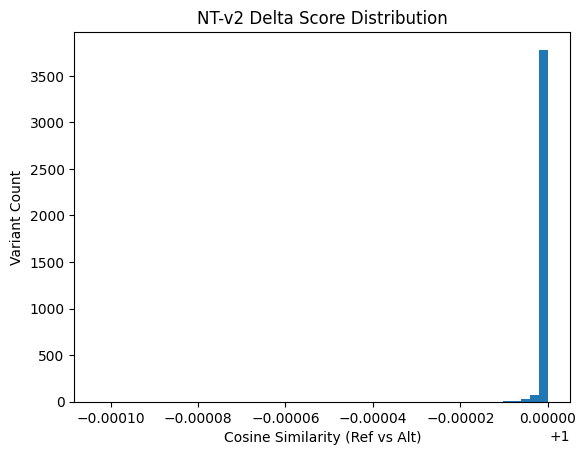

In [43]:
import matplotlib.pyplot as plt

plt.hist(ntv2_df['ntv2_delta_score'], bins=50)
plt.title("NT-v2 Delta Score Distribution")
plt.xlabel("Cosine Similarity (Ref vs Alt)")
plt.ylabel("Variant Count")
plt.show()


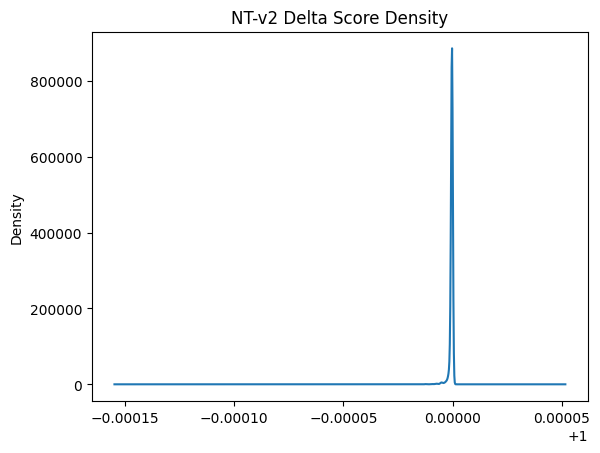

In [44]:
ntv2_df['ntv2_delta_score'].plot(kind='kde', title='NT-v2 Delta Score Density')
plt.show()


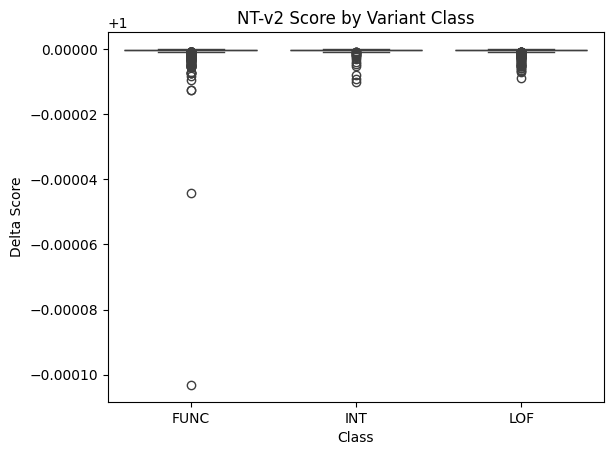

In [45]:
import seaborn as sns

sns.boxplot(data=ntv2_df, x='class', y='ntv2_delta_score')
plt.title("NT-v2 Score by Variant Class")
plt.xlabel("Class")
plt.ylabel("Delta Score")
plt.show()


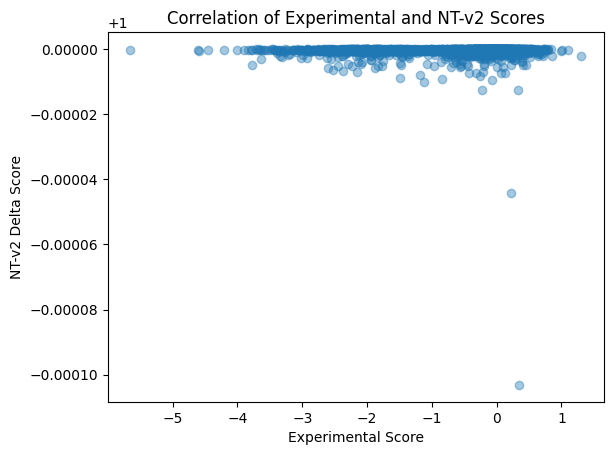

In [46]:
plt.scatter(ntv2_df['score'], ntv2_df['ntv2_delta_score'], alpha=0.4)
plt.xlabel('Experimental Score')
plt.ylabel('NT-v2 Delta Score')
plt.title('Correlation of Experimental and NT-v2 Scores')
plt.show()
